In [1]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import clip
import open_clip

import utils
import data_utils

from torch.utils.data import DataLoader, TensorDataset
from glm_saga.elasticnet import IndexedTensorDataset, glm_saga

In [2]:
device = "cuda"
dataset_name = "imagenet_val"
batch_size = 256
save_dir = 'saved_activations'
clip_name = "ViT-L-16-SigLIP-384"#"ViT-B/16"#"ViT-L/14@336px"#
openclip = True
concept_set = "data/filtered_20k_new.txt"#"data/combined_concepts.txt"#"data/20k.txt"
target_name = "resnet50"
target_layer = "layer4"
target_neurons = [i for i in range(50)]

if openclip:
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(clip_name.split("_")[-1], pretrained="webli",
                                                                       device=device)
else:
    clip_model, clip_preprocess = clip.load(clip_name, device=device)

model, preprocess = data_utils.get_target_model(target_name, device=device)

In [3]:
dataset = data_utils.get_data(dataset_name, preprocess)
clip_data = data_utils.get_data(dataset_name, clip_preprocess)

In [4]:
clip_save_name = "{}/{}_{}.pt".format(save_dir, dataset_name, clip_name.replace('/', ''))
utils.save_clip_image_features(clip_model, clip_data, clip_save_name, batch_size, device)
clip_image_features = torch.load(clip_save_name, map_location=device).float()

In [5]:
with open(concept_set, 'r') as f: 
    text = (f.read()).split('\n')
if openclip:
    tokenized_text = open_clip.get_tokenizer(clip_name.split("_")[-1])(text).to(device)
else:
    tokenized_text = clip.tokenize(text).to(device)
    avg_emb_path = "{}/20k_avg_{}.pt".format(save_dir, clip_name.replace("/", ""))
    avg_text_emb = utils.save_clip_avg_20k(clip_model, avg_emb_path, batch_size=1000, device=device)

text_save_name = "{}/{}_{}.pt".format(save_dir, concept_set.split("/")[-1].split(".")[0], clip_name.replace('/', ''))
clip_text_features = utils.get_clip_text_features(clip_model, tokenized_text).float()

In [6]:
a = utils.SIGMOID_PARAMS[clip_name]["a"]#60
b = utils.SIGMOID_PARAMS[clip_name]["b"]#-0.08#-0.07

with torch.no_grad():
    clip_image_features /= clip_image_features.norm(dim=-1, keepdim=True)
    clip_text_features /= clip_text_features.norm(dim=-1, keepdim=True)
    if openclip:
        clip_feats = clip_image_features @ (clip_text_features).T
    else:
        clip_feats = (clip_image_features @ (clip_text_features-avg_text_emb).T)
    clip_feats = torch.nn.functional.sigmoid(a*(clip_feats+b))

print(clip_feats.shape)
print(torch.mean(torch.sum(clip_feats, dim=1)))

##load ensemble results
# with torch.no_grad():
#     clip_feats = torch.nn.functional.sigmoid(a*(torch.load("saved_activations/clip_feats_ensemble_imagenet_filtered_20k.pt")+b))

torch.Size([50000, 14862])
tensor(111.0096, device='cuda:0')


In [7]:
mean_text = torch.mean(clip_feats, dim=0)
std_text = torch.std(clip_feats, dim=0)
print(mean_text, mean_text.shape)
vals, ids = torch.sort(mean_text, descending=True)
for id in ids[:5]:
    print(text[id], mean_text[id].cpu(), std_text[id].cpu())

tensor([0.0347, 0.0022, 0.0003,  ..., 0.0126, 0.0275, 0.0009], device='cuda:0') torch.Size([14862])
fauna tensor(0.0955) tensor(0.1385)
cao tensor(0.0892) tensor(0.1253)
beg tensor(0.0889) tensor(0.0935)
orig tensor(0.0888) tensor(0.0685)
tier tensor(0.0848) tensor(0.1167)


In [8]:
vals, ids = torch.sort(std_text, descending=False)
for id in ids[0:5]:
    print(text[id], mean_text[id].cpu(), std_text[id].cpu())

commented tensor(4.7496e-05) tensor(0.0005)
notion tensor(3.8516e-05) tensor(0.0006)
bootstrap tensor(7.1456e-05) tensor(0.0007)
subscribe tensor(7.5272e-05) tensor(0.0007)
pdf tensor(0.0002) tensor(0.0007)


## Deleting concepts that are not active on the dataset

In [9]:
active_concepts = std_text>0.002
clip_feats = clip_feats[:, active_concepts]
text = [concept for i, concept in enumerate(text) if active_concepts[i]]
print(len(text), clip_feats.shape)

mean_text = mean_text[active_concepts]
std_text = std_text[active_concepts]

14713 torch.Size([50000, 14713])


In [10]:
#print(mean_text[text.index("yellow")])
pil_data = data_utils.get_data(dataset_name)

lizard tensor(0.9146)
reptiles tensor(0.7256)
mos tensor(0.4885)
macro tensor(0.4159)
opteron tensor(0.4140)
ivy tensor(0.3882)
fauna tensor(0.3842)
organisms tensor(0.3769)
bud tensor(0.3537)
leaves tensor(0.3495)
emerged tensor(0.3327)
hiding tensor(0.3220)
nutten tensor(0.3113)
leaf tensor(0.2960)
foliage tensor(0.2736)
vegetation tensor(0.2706)
mating tensor(0.2661)
tended tensor(0.2637)
grows tensor(0.2629)
wildlife tensor(0.2611)


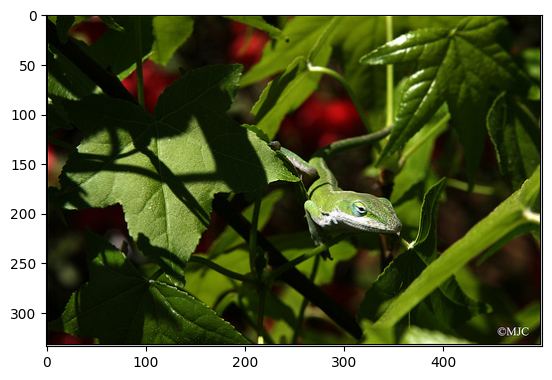

In [11]:
img_id = 2000

plt.imshow(pil_data[img_id][0])
vals, ids = torch.sort(clip_feats[img_id], descending=True)
for id in ids[:20]:
    print(text[id], clip_feats[img_id, id].cpu())

In [12]:
summary_activations = []

layer_save_path = '{}/{}_{}/{}/'.format(save_dir, target_name, dataset_name, target_layer)
#for target_neuron in target_neurons:
activations = utils.save_summary_activations(model, dataset, device, target_layer, batch_size, layer_save_path)
summary_activations = [activations[:, neuron:neuron+1] for neuron in target_neurons]
summary_activations = torch.cat(summary_activations, dim=1)

print(summary_activations.shape)
del clip_image_features, clip_text_features, activations
torch.cuda.empty_cache()

torch.Size([50000, 50])


In [13]:
train_ids = torch.load("data/imagenet_val_splits/train_ids.pt")
val_ids = torch.load("data/imagenet_val_splits/val_ids.pt")

train_data = clip_feats[train_ids].float()
val_data = clip_feats[val_ids].float()

train_target = summary_activations[train_ids]
val_target = summary_activations[val_ids]

del clip_feats
torch.cuda.empty_cache()

In [14]:
with torch.no_grad():
    train_mean = torch.mean(train_data, dim=0, keepdim=True)
    train_std = torch.std(train_data, dim=0, keepdim=True)
    #print(train_mean, train_std)
    train_data -= train_mean
    train_data /= train_std

    target_mean = torch.mean(summary_activations, dim=0, keepdim=True)
    target_std = torch.std(summary_activations, dim=0, keepdim=True)
    train_target = (train_target-target_mean)/target_std
    indexed_train_ds = IndexedTensorDataset(train_data, train_target)

    val_data -= train_mean
    val_data /= train_std

    val_target = (val_target - target_mean)/target_std
    
    val_ds = TensorDataset(val_data, val_target)

In [15]:
saga_batch_size = 512#256 best with one neuron at a time
n_iters = 500
lam = 5e-2#7e-2#5e-2#3e-2 was best with one neuron at a time

indexed_train_loader = DataLoader(indexed_train_ds, batch_size=saga_batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=saga_batch_size, shuffle=False)

linear = torch.nn.Linear(in_features = train_data.shape[1], out_features = len(target_neurons)).to(device)
linear.weight.data.zero_()
linear.bias.data.zero_()

STEP_SIZE = 5e-4#7e-4#1e-4#3e-5#7e-4 best with one neuron at a time
ALPHA = 0.99#0.99 best for one neuron at a time
metadata = {}
metadata['max_reg'] = {}
metadata['max_reg']['nongrouped'] = lam
#lookbehind=10, tol=1e-7 was best with one neuron at a time
output_proj = glm_saga(linear, indexed_train_loader, STEP_SIZE, n_iters, ALPHA, epsilon=1, k=1, val_loader = val_loader,
                       n_ex=len(train_data), do_zero=False, metadata=metadata, n_classes = len(target_neurons), family='gaussian',
                       lookbehind=5, tol=1e-4, verbose=True)

W_g = output_proj['path'][0]['weight']
b_g = output_proj['path'][0]['bias']

  0%|▏                                                                                 | 1/500 [00:01<13:01,  1.57s/it]

obj 25.834518432617188 weight nnz 273849/735650 (0.3723) obj_best 25.834518432617188


  0%|▎                                                                                 | 2/500 [00:02<12:14,  1.47s/it]

obj 22.415660858154297 weight nnz 44934/735650 (0.0611) obj_best 22.415660858154297


  1%|▍                                                                                 | 3/500 [00:04<11:51,  1.43s/it]

obj 22.7102108001709 weight nnz 35175/735650 (0.0478) obj_best 22.415660858154297


  1%|▋                                                                                 | 4/500 [00:05<12:00,  1.45s/it]

obj 22.410682678222656 weight nnz 27617/735650 (0.0375) obj_best 22.410682678222656


  1%|▊                                                                                 | 5/500 [00:07<11:44,  1.42s/it]

obj 22.3339900970459 weight nnz 24019/735650 (0.0327) obj_best 22.3339900970459


  1%|▉                                                                                 | 6/500 [00:08<11:35,  1.41s/it]

obj 22.226245880126953 weight nnz 21309/735650 (0.0290) obj_best 22.226245880126953


  1%|█▏                                                                                | 7/500 [00:09<11:32,  1.41s/it]

obj 22.151714324951172 weight nnz 19368/735650 (0.0263) obj_best 22.151714324951172


  2%|█▎                                                                                | 8/500 [00:11<11:49,  1.44s/it]

obj 22.084375381469727 weight nnz 17855/735650 (0.0243) obj_best 22.084375381469727


  2%|█▍                                                                                | 9/500 [00:12<11:41,  1.43s/it]

obj 22.02907371520996 weight nnz 16647/735650 (0.0226) obj_best 22.02907371520996


  2%|█▌                                                                               | 10/500 [00:14<11:35,  1.42s/it]

obj 21.981229782104492 weight nnz 15585/735650 (0.0212) obj_best 21.981229782104492


  2%|█▊                                                                               | 11/500 [00:15<11:28,  1.41s/it]

obj 21.93916893005371 weight nnz 14704/735650 (0.0200) obj_best 21.93916893005371


  2%|█▉                                                                               | 12/500 [00:17<11:20,  1.39s/it]

obj 21.9027156829834 weight nnz 13992/735650 (0.0190) obj_best 21.9027156829834


  3%|██                                                                               | 13/500 [00:18<11:15,  1.39s/it]

obj 21.870141983032227 weight nnz 13382/735650 (0.0182) obj_best 21.870141983032227


  3%|██▎                                                                              | 14/500 [00:19<11:16,  1.39s/it]

obj 21.841100692749023 weight nnz 12809/735650 (0.0174) obj_best 21.841100692749023


  3%|██▍                                                                              | 15/500 [00:21<11:34,  1.43s/it]

obj 21.815317153930664 weight nnz 12278/735650 (0.0167) obj_best 21.815317153930664


  3%|██▌                                                                              | 16/500 [00:22<11:29,  1.42s/it]

obj 21.79208755493164 weight nnz 11810/735650 (0.0161) obj_best 21.79208755493164


  3%|██▊                                                                              | 17/500 [00:24<11:24,  1.42s/it]

obj 21.77069664001465 weight nnz 11413/735650 (0.0155) obj_best 21.77069664001465


  4%|██▉                                                                              | 18/500 [00:25<11:17,  1.41s/it]

obj 21.751235961914062 weight nnz 11041/735650 (0.0150) obj_best 21.751235961914062


  4%|███                                                                              | 19/500 [00:27<11:25,  1.43s/it]

obj 21.733474731445312 weight nnz 10694/735650 (0.0145) obj_best 21.733474731445312


  4%|███▏                                                                             | 20/500 [00:28<11:15,  1.41s/it]

obj 21.717182159423828 weight nnz 10373/735650 (0.0141) obj_best 21.717182159423828


  4%|███▍                                                                             | 21/500 [00:29<11:11,  1.40s/it]

obj 21.70208740234375 weight nnz 10086/735650 (0.0137) obj_best 21.70208740234375


  4%|███▌                                                                             | 22/500 [00:31<11:09,  1.40s/it]

obj 21.688241958618164 weight nnz 9808/735650 (0.0133) obj_best 21.688241958618164


  5%|███▋                                                                             | 23/500 [00:32<11:08,  1.40s/it]

obj 21.67546272277832 weight nnz 9572/735650 (0.0130) obj_best 21.67546272277832


  5%|███▉                                                                             | 24/500 [00:33<11:06,  1.40s/it]

obj 21.663732528686523 weight nnz 9333/735650 (0.0127) obj_best 21.663732528686523


  5%|████                                                                             | 25/500 [00:35<11:00,  1.39s/it]

obj 21.65240478515625 weight nnz 9130/735650 (0.0124) obj_best 21.65240478515625


  5%|████▏                                                                            | 26/500 [00:36<11:11,  1.42s/it]

obj 21.641984939575195 weight nnz 8958/735650 (0.0122) obj_best 21.641984939575195


  5%|████▎                                                                            | 27/500 [00:38<11:05,  1.41s/it]

obj 21.632293701171875 weight nnz 8779/735650 (0.0119) obj_best 21.632293701171875


  6%|████▌                                                                            | 28/500 [00:39<11:02,  1.40s/it]

obj 21.62301254272461 weight nnz 8619/735650 (0.0117) obj_best 21.62301254272461


  6%|████▋                                                                            | 29/500 [00:41<11:02,  1.41s/it]

obj 21.61458969116211 weight nnz 8438/735650 (0.0115) obj_best 21.61458969116211


  6%|████▊                                                                            | 30/500 [00:42<11:14,  1.44s/it]

obj 21.606571197509766 weight nnz 8300/735650 (0.0113) obj_best 21.606571197509766


  6%|█████                                                                            | 31/500 [00:43<11:07,  1.42s/it]

obj 21.59902572631836 weight nnz 8161/735650 (0.0111) obj_best 21.59902572631836


  6%|█████▏                                                                           | 32/500 [00:45<10:58,  1.41s/it]

obj 21.591888427734375 weight nnz 8044/735650 (0.0109) obj_best 21.591888427734375


  7%|█████▎                                                                           | 33/500 [00:46<10:53,  1.40s/it]

obj 21.585041046142578 weight nnz 7924/735650 (0.0108) obj_best 21.585041046142578


  7%|█████▌                                                                           | 34/500 [00:48<10:51,  1.40s/it]

obj 21.57868003845215 weight nnz 7802/735650 (0.0106) obj_best 21.57868003845215


  7%|█████▋                                                                           | 35/500 [00:49<10:51,  1.40s/it]

obj 21.572620391845703 weight nnz 7680/735650 (0.0104) obj_best 21.572620391845703


  7%|█████▊                                                                           | 36/500 [00:50<10:54,  1.41s/it]

obj 21.56689453125 weight nnz 7577/735650 (0.0103) obj_best 21.56689453125


  7%|█████▉                                                                           | 37/500 [00:52<11:09,  1.45s/it]

obj 21.561487197875977 weight nnz 7458/735650 (0.0101) obj_best 21.561487197875977


  8%|██████▏                                                                          | 38/500 [00:53<11:01,  1.43s/it]

obj 21.556360244750977 weight nnz 7374/735650 (0.0100) obj_best 21.556360244750977


  8%|██████▎                                                                          | 39/500 [00:55<10:52,  1.42s/it]

obj 21.551450729370117 weight nnz 7290/735650 (0.0099) obj_best 21.551450729370117


  8%|██████▍                                                                          | 40/500 [00:56<10:47,  1.41s/it]

obj 21.54682731628418 weight nnz 7201/735650 (0.0098) obj_best 21.54682731628418


  8%|██████▋                                                                          | 41/500 [00:58<10:58,  1.44s/it]

obj 21.542402267456055 weight nnz 7120/735650 (0.0097) obj_best 21.542402267456055


  8%|██████▊                                                                          | 42/500 [00:59<10:54,  1.43s/it]

obj 21.53823471069336 weight nnz 7034/735650 (0.0096) obj_best 21.53823471069336


  9%|██████▉                                                                          | 43/500 [01:00<10:50,  1.42s/it]

obj 21.53416633605957 weight nnz 6961/735650 (0.0095) obj_best 21.53416633605957


  9%|███████▏                                                                         | 44/500 [01:02<10:45,  1.42s/it]

obj 21.530324935913086 weight nnz 6879/735650 (0.0094) obj_best 21.530324935913086


  9%|███████▎                                                                         | 45/500 [01:03<10:43,  1.41s/it]

obj 21.526689529418945 weight nnz 6807/735650 (0.0093) obj_best 21.526689529418945


  9%|███████▍                                                                         | 46/500 [01:05<10:41,  1.41s/it]

obj 21.523174285888672 weight nnz 6728/735650 (0.0091) obj_best 21.523174285888672


  9%|███████▌                                                                         | 47/500 [01:06<10:36,  1.40s/it]

obj 21.519899368286133 weight nnz 6648/735650 (0.0090) obj_best 21.519899368286133


 10%|███████▊                                                                         | 48/500 [01:07<10:45,  1.43s/it]

obj 21.516735076904297 weight nnz 6576/735650 (0.0089) obj_best 21.516735076904297


 10%|███████▉                                                                         | 49/500 [01:09<10:35,  1.41s/it]

obj 21.513622283935547 weight nnz 6523/735650 (0.0089) obj_best 21.513622283935547


 10%|████████                                                                         | 50/500 [01:10<10:31,  1.40s/it]

obj 21.51073455810547 weight nnz 6468/735650 (0.0088) obj_best 21.51073455810547


 10%|████████▎                                                                        | 51/500 [01:12<10:29,  1.40s/it]

obj 21.507877349853516 weight nnz 6402/735650 (0.0087) obj_best 21.507877349853516


 10%|████████▍                                                                        | 52/500 [01:13<10:43,  1.44s/it]

obj 21.50523567199707 weight nnz 6348/735650 (0.0086) obj_best 21.50523567199707


 11%|████████▌                                                                        | 53/500 [01:15<10:41,  1.43s/it]

obj 21.502647399902344 weight nnz 6300/735650 (0.0086) obj_best 21.502647399902344


 11%|████████▋                                                                        | 54/500 [01:16<10:30,  1.41s/it]

obj 21.500194549560547 weight nnz 6242/735650 (0.0085) obj_best 21.500194549560547


 11%|████████▉                                                                        | 55/500 [01:17<10:22,  1.40s/it]

obj 21.497804641723633 weight nnz 6202/735650 (0.0084) obj_best 21.497804641723633


 11%|█████████                                                                        | 56/500 [01:19<10:19,  1.40s/it]

obj 21.49553871154785 weight nnz 6156/735650 (0.0084) obj_best 21.49553871154785


 11%|█████████▏                                                                       | 57/500 [01:20<10:16,  1.39s/it]

obj 21.49336051940918 weight nnz 6097/735650 (0.0083) obj_best 21.49336051940918


 12%|█████████▍                                                                       | 58/500 [01:21<10:16,  1.39s/it]

obj 21.49125099182129 weight nnz 6060/735650 (0.0082) obj_best 21.49125099182129


 12%|█████████▌                                                                       | 59/500 [01:23<10:30,  1.43s/it]

obj 21.48919677734375 weight nnz 6017/735650 (0.0082) obj_best 21.48919677734375


 12%|█████████▋                                                                       | 60/500 [01:24<10:28,  1.43s/it]

obj 21.487234115600586 weight nnz 5985/735650 (0.0081) obj_best 21.487234115600586


 12%|█████████▉                                                                       | 61/500 [01:26<10:22,  1.42s/it]

obj 21.48533058166504 weight nnz 5943/735650 (0.0081) obj_best 21.48533058166504


 12%|██████████                                                                       | 62/500 [01:27<10:14,  1.40s/it]

obj 21.483562469482422 weight nnz 5899/735650 (0.0080) obj_best 21.483562469482422


 13%|██████████▏                                                                      | 63/500 [01:29<10:35,  1.45s/it]

obj 21.481840133666992 weight nnz 5865/735650 (0.0080) obj_best 21.481840133666992


 13%|██████████▎                                                                      | 64/500 [01:30<10:29,  1.44s/it]

obj 21.48013687133789 weight nnz 5832/735650 (0.0079) obj_best 21.48013687133789


 13%|██████████▌                                                                      | 65/500 [01:32<10:23,  1.43s/it]

obj 21.478513717651367 weight nnz 5804/735650 (0.0079) obj_best 21.478513717651367


 13%|██████████▋                                                                      | 66/500 [01:33<10:22,  1.43s/it]

obj 21.476938247680664 weight nnz 5763/735650 (0.0078) obj_best 21.476938247680664


 13%|██████████▊                                                                      | 67/500 [01:34<10:16,  1.42s/it]

obj 21.475454330444336 weight nnz 5729/735650 (0.0078) obj_best 21.475454330444336


 14%|███████████                                                                      | 68/500 [01:36<10:09,  1.41s/it]

obj 21.47396469116211 weight nnz 5702/735650 (0.0078) obj_best 21.47396469116211


 14%|███████████▏                                                                     | 69/500 [01:37<10:07,  1.41s/it]

obj 21.472553253173828 weight nnz 5656/735650 (0.0077) obj_best 21.472553253173828


 14%|███████████▎                                                                     | 70/500 [01:39<10:13,  1.43s/it]

obj 21.471208572387695 weight nnz 5621/735650 (0.0076) obj_best 21.471208572387695


 14%|███████████▌                                                                     | 71/500 [01:40<10:09,  1.42s/it]

obj 21.46987533569336 weight nnz 5591/735650 (0.0076) obj_best 21.46987533569336


 14%|███████████▋                                                                     | 72/500 [01:42<10:07,  1.42s/it]

obj 21.468589782714844 weight nnz 5559/735650 (0.0076) obj_best 21.468589782714844


 15%|███████████▊                                                                     | 73/500 [01:43<10:05,  1.42s/it]

obj 21.46735954284668 weight nnz 5531/735650 (0.0075) obj_best 21.46735954284668


 15%|███████████▉                                                                     | 74/500 [01:44<10:16,  1.45s/it]

obj 21.466167449951172 weight nnz 5507/735650 (0.0075) obj_best 21.466167449951172


 15%|████████████▏                                                                    | 75/500 [01:46<10:07,  1.43s/it]

obj 21.464962005615234 weight nnz 5481/735650 (0.0075) obj_best 21.464962005615234


 15%|████████████▎                                                                    | 76/500 [01:47<09:59,  1.41s/it]

obj 21.46383285522461 weight nnz 5463/735650 (0.0074) obj_best 21.46383285522461


 15%|████████████▍                                                                    | 77/500 [01:49<10:00,  1.42s/it]

obj 21.46272850036621 weight nnz 5446/735650 (0.0074) obj_best 21.46272850036621


 16%|████████████▋                                                                    | 78/500 [01:50<09:51,  1.40s/it]

obj 21.461641311645508 weight nnz 5424/735650 (0.0074) obj_best 21.461641311645508


 16%|████████████▊                                                                    | 79/500 [01:51<09:49,  1.40s/it]

obj 21.46059799194336 weight nnz 5402/735650 (0.0073) obj_best 21.46059799194336


 16%|████████████▉                                                                    | 80/500 [01:53<09:52,  1.41s/it]

obj 21.459617614746094 weight nnz 5372/735650 (0.0073) obj_best 21.459617614746094


 16%|█████████████                                                                    | 81/500 [01:54<10:08,  1.45s/it]

obj 21.458637237548828 weight nnz 5350/735650 (0.0073) obj_best 21.458637237548828


 16%|█████████████▎                                                                   | 82/500 [01:56<09:59,  1.43s/it]

obj 21.457691192626953 weight nnz 5325/735650 (0.0072) obj_best 21.457691192626953


 17%|█████████████▍                                                                   | 83/500 [01:57<09:51,  1.42s/it]

obj 21.45675277709961 weight nnz 5312/735650 (0.0072) obj_best 21.45675277709961


 17%|█████████████▌                                                                   | 84/500 [01:59<09:44,  1.41s/it]

obj 21.45585060119629 weight nnz 5300/735650 (0.0072) obj_best 21.45585060119629


 17%|█████████████▊                                                                   | 85/500 [02:00<09:52,  1.43s/it]

obj 21.454994201660156 weight nnz 5274/735650 (0.0072) obj_best 21.454994201660156


 17%|█████████████▉                                                                   | 86/500 [02:01<09:45,  1.42s/it]

obj 21.454143524169922 weight nnz 5236/735650 (0.0071) obj_best 21.454143524169922


 17%|██████████████                                                                   | 87/500 [02:03<09:42,  1.41s/it]

obj 21.453338623046875 weight nnz 5218/735650 (0.0071) obj_best 21.453338623046875


 18%|██████████████▎                                                                  | 88/500 [02:04<09:42,  1.41s/it]

obj 21.45250701904297 weight nnz 5196/735650 (0.0071) obj_best 21.45250701904297


 18%|██████████████▍                                                                  | 89/500 [02:06<09:38,  1.41s/it]

obj 21.451738357543945 weight nnz 5170/735650 (0.0070) obj_best 21.451738357543945


 18%|██████████████▌                                                                  | 90/500 [02:07<09:35,  1.40s/it]

obj 21.450977325439453 weight nnz 5158/735650 (0.0070) obj_best 21.450977325439453


 18%|██████████████▋                                                                  | 91/500 [02:08<09:34,  1.40s/it]

obj 21.450212478637695 weight nnz 5141/735650 (0.0070) obj_best 21.450212478637695


 18%|██████████████▉                                                                  | 92/500 [02:10<09:42,  1.43s/it]

obj 21.449522018432617 weight nnz 5124/735650 (0.0070) obj_best 21.449522018432617


 19%|███████████████                                                                  | 93/500 [02:11<09:37,  1.42s/it]

obj 21.448823928833008 weight nnz 5104/735650 (0.0069) obj_best 21.448823928833008


 19%|███████████████▏                                                                 | 94/500 [02:13<09:35,  1.42s/it]

obj 21.4481201171875 weight nnz 5087/735650 (0.0069) obj_best 21.4481201171875


 19%|███████████████▍                                                                 | 95/500 [02:14<09:39,  1.43s/it]

obj 21.447467803955078 weight nnz 5070/735650 (0.0069) obj_best 21.447467803955078


 19%|███████████████▌                                                                 | 96/500 [02:16<09:50,  1.46s/it]

obj 21.446813583374023 weight nnz 5054/735650 (0.0069) obj_best 21.446813583374023


 19%|███████████████▋                                                                 | 97/500 [02:17<09:39,  1.44s/it]

obj 21.446178436279297 weight nnz 5041/735650 (0.0069) obj_best 21.446178436279297


 20%|███████████████▉                                                                 | 98/500 [02:18<09:30,  1.42s/it]

obj 21.4455509185791 weight nnz 5027/735650 (0.0068) obj_best 21.4455509185791


 20%|████████████████                                                                 | 99/500 [02:20<09:21,  1.40s/it]

obj 21.444969177246094 weight nnz 5007/735650 (0.0068) obj_best 21.444969177246094


 20%|████████████████                                                                | 100/500 [02:21<09:21,  1.40s/it]

obj 21.444387435913086 weight nnz 4995/735650 (0.0068) obj_best 21.444387435913086


 20%|████████████████▏                                                               | 101/500 [02:23<09:22,  1.41s/it]

obj 21.44380760192871 weight nnz 4978/735650 (0.0068) obj_best 21.44380760192871


 20%|████████████████▎                                                               | 102/500 [02:24<09:19,  1.41s/it]

obj 21.443260192871094 weight nnz 4965/735650 (0.0067) obj_best 21.443260192871094


 21%|████████████████▍                                                               | 103/500 [02:26<09:34,  1.45s/it]

obj 21.44271469116211 weight nnz 4949/735650 (0.0067) obj_best 21.44271469116211


 21%|████████████████▋                                                               | 104/500 [02:27<09:23,  1.42s/it]

obj 21.44219398498535 weight nnz 4935/735650 (0.0067) obj_best 21.44219398498535


 21%|████████████████▊                                                               | 105/500 [02:28<09:16,  1.41s/it]

obj 21.441688537597656 weight nnz 4919/735650 (0.0067) obj_best 21.441688537597656


 21%|████████████████▉                                                               | 106/500 [02:30<09:20,  1.42s/it]

obj 21.44118309020996 weight nnz 4906/735650 (0.0067) obj_best 21.44118309020996


 21%|█████████████████                                                               | 107/500 [02:31<09:24,  1.44s/it]

obj 21.44069480895996 weight nnz 4891/735650 (0.0066) obj_best 21.44069480895996


 22%|█████████████████▎                                                              | 108/500 [02:33<09:19,  1.43s/it]

obj 21.440214157104492 weight nnz 4880/735650 (0.0066) obj_best 21.440214157104492


 22%|█████████████████▍                                                              | 109/500 [02:34<09:14,  1.42s/it]

obj 21.439743041992188 weight nnz 4862/735650 (0.0066) obj_best 21.439743041992188


 22%|█████████████████▌                                                              | 110/500 [02:35<09:10,  1.41s/it]

obj 21.43929100036621 weight nnz 4847/735650 (0.0066) obj_best 21.43929100036621


 22%|█████████████████▊                                                              | 111/500 [02:37<09:07,  1.41s/it]

obj 21.438852310180664 weight nnz 4830/735650 (0.0066) obj_best 21.438852310180664


 22%|█████████████████▉                                                              | 112/500 [02:38<09:02,  1.40s/it]

obj 21.438432693481445 weight nnz 4821/735650 (0.0066) obj_best 21.438432693481445


 23%|██████████████████                                                              | 113/500 [02:40<08:57,  1.39s/it]

obj 21.438013076782227 weight nnz 4809/735650 (0.0065) obj_best 21.438013076782227


 23%|██████████████████▏                                                             | 114/500 [02:41<08:55,  1.39s/it]

obj 21.437589645385742 weight nnz 4800/735650 (0.0065) obj_best 21.437589645385742


 23%|██████████████████▍                                                             | 115/500 [02:42<09:08,  1.42s/it]

obj 21.437179565429688 weight nnz 4787/735650 (0.0065) obj_best 21.437179565429688


 23%|██████████████████▌                                                             | 116/500 [02:44<09:06,  1.42s/it]

obj 21.436792373657227 weight nnz 4777/735650 (0.0065) obj_best 21.436792373657227


 23%|██████████████████▋                                                             | 117/500 [02:45<09:02,  1.42s/it]

obj 21.4364070892334 weight nnz 4764/735650 (0.0065) obj_best 21.4364070892334


 24%|██████████████████▉                                                             | 118/500 [02:47<09:12,  1.45s/it]

obj 21.43603515625 weight nnz 4758/735650 (0.0065) obj_best 21.43603515625


 24%|███████████████████                                                             | 119/500 [02:48<09:01,  1.42s/it]

obj 21.435651779174805 weight nnz 4754/735650 (0.0065) obj_best 21.435651779174805


 24%|███████████████████▏                                                            | 120/500 [02:50<08:57,  1.42s/it]

obj 21.43528938293457 weight nnz 4745/735650 (0.0065) obj_best 21.43528938293457


 24%|███████████████████▎                                                            | 121/500 [02:51<08:52,  1.40s/it]

obj 21.434947967529297 weight nnz 4735/735650 (0.0064) obj_best 21.434947967529297


 24%|███████████████████▌                                                            | 122/500 [02:52<08:49,  1.40s/it]

obj 21.434593200683594 weight nnz 4726/735650 (0.0064) obj_best 21.434593200683594


 25%|███████████████████▋                                                            | 123/500 [02:54<08:47,  1.40s/it]

obj 21.434253692626953 weight nnz 4720/735650 (0.0064) obj_best 21.434253692626953


 25%|███████████████████▊                                                            | 124/500 [02:55<08:47,  1.40s/it]

obj 21.433917999267578 weight nnz 4718/735650 (0.0064) obj_best 21.433917999267578


 25%|████████████████████                                                            | 125/500 [02:57<08:46,  1.40s/it]

obj 21.433595657348633 weight nnz 4705/735650 (0.0064) obj_best 21.433595657348633


 25%|████████████████████▏                                                           | 126/500 [02:58<08:52,  1.42s/it]

obj 21.43328285217285 weight nnz 4696/735650 (0.0064) obj_best 21.43328285217285


 25%|████████████████████▎                                                           | 127/500 [02:59<08:44,  1.41s/it]

obj 21.432968139648438 weight nnz 4692/735650 (0.0064) obj_best 21.432968139648438


 26%|████████████████████▍                                                           | 128/500 [03:01<08:38,  1.40s/it]

obj 21.432662963867188 weight nnz 4686/735650 (0.0064) obj_best 21.432662963867188


 26%|████████████████████▋                                                           | 129/500 [03:02<08:36,  1.39s/it]

obj 21.432363510131836 weight nnz 4678/735650 (0.0064) obj_best 21.432363510131836


 26%|████████████████████▊                                                           | 130/500 [03:04<08:52,  1.44s/it]

obj 21.43206787109375 weight nnz 4668/735650 (0.0063) obj_best 21.43206787109375


 26%|████████████████████▉                                                           | 131/500 [03:05<08:46,  1.43s/it]

obj 21.431781768798828 weight nnz 4660/735650 (0.0063) obj_best 21.431781768798828


 26%|█████████████████████                                                           | 132/500 [03:07<08:41,  1.42s/it]

obj 21.431495666503906 weight nnz 4650/735650 (0.0063) obj_best 21.431495666503906


 27%|█████████████████████▎                                                          | 133/500 [03:08<08:35,  1.40s/it]

obj 21.43122673034668 weight nnz 4641/735650 (0.0063) obj_best 21.43122673034668


 27%|█████████████████████▍                                                          | 134/500 [03:09<08:29,  1.39s/it]

obj 21.430950164794922 weight nnz 4637/735650 (0.0063) obj_best 21.430950164794922


 27%|█████████████████████▌                                                          | 135/500 [03:11<08:24,  1.38s/it]

obj 21.430700302124023 weight nnz 4624/735650 (0.0063) obj_best 21.430700302124023


 27%|█████████████████████▊                                                          | 136/500 [03:12<08:22,  1.38s/it]

obj 21.430442810058594 weight nnz 4613/735650 (0.0063) obj_best 21.430442810058594


 27%|█████████████████████▉                                                          | 137/500 [03:14<08:36,  1.42s/it]

obj 21.43019676208496 weight nnz 4603/735650 (0.0063) obj_best 21.43019676208496


 28%|██████████████████████                                                          | 138/500 [03:15<08:34,  1.42s/it]

obj 21.429956436157227 weight nnz 4592/735650 (0.0062) obj_best 21.429956436157227


 28%|██████████████████████▏                                                         | 139/500 [03:16<08:31,  1.42s/it]

obj 21.429718017578125 weight nnz 4587/735650 (0.0062) obj_best 21.429718017578125


 28%|██████████████████████▍                                                         | 140/500 [03:18<08:26,  1.41s/it]

obj 21.42947006225586 weight nnz 4586/735650 (0.0062) obj_best 21.42947006225586


 28%|██████████████████████▌                                                         | 141/500 [03:19<08:33,  1.43s/it]

obj 21.42923355102539 weight nnz 4582/735650 (0.0062) obj_best 21.42923355102539


 28%|██████████████████████▋                                                         | 142/500 [03:21<08:24,  1.41s/it]

obj 21.429012298583984 weight nnz 4576/735650 (0.0062) obj_best 21.429012298583984


 29%|██████████████████████▉                                                         | 143/500 [03:22<08:18,  1.40s/it]

obj 21.42878532409668 weight nnz 4570/735650 (0.0062) obj_best 21.42878532409668


 29%|███████████████████████                                                         | 144/500 [03:23<08:16,  1.39s/it]

obj 21.42856788635254 weight nnz 4567/735650 (0.0062) obj_best 21.42856788635254


 29%|███████████████████████▏                                                        | 145/500 [03:25<08:17,  1.40s/it]

obj 21.428354263305664 weight nnz 4561/735650 (0.0062) obj_best 21.428354263305664


 29%|███████████████████████▎                                                        | 146/500 [03:26<08:17,  1.40s/it]

obj 21.42815399169922 weight nnz 4553/735650 (0.0062) obj_best 21.42815399169922


 29%|███████████████████████▌                                                        | 147/500 [03:28<08:15,  1.41s/it]

obj 21.427936553955078 weight nnz 4549/735650 (0.0062) obj_best 21.427936553955078


 30%|███████████████████████▋                                                        | 148/500 [03:29<08:21,  1.42s/it]

obj 21.427738189697266 weight nnz 4546/735650 (0.0062) obj_best 21.427738189697266


 30%|███████████████████████▊                                                        | 149/500 [03:30<08:13,  1.41s/it]

obj 21.427541732788086 weight nnz 4543/735650 (0.0062) obj_best 21.427541732788086


 30%|████████████████████████                                                        | 150/500 [03:32<08:08,  1.40s/it]

obj 21.42734718322754 weight nnz 4532/735650 (0.0062) obj_best 21.42734718322754


 30%|████████████████████████▏                                                       | 151/500 [03:33<08:05,  1.39s/it]

obj 21.427162170410156 weight nnz 4529/735650 (0.0062) obj_best 21.427162170410156


 30%|████████████████████████▎                                                       | 152/500 [03:35<08:20,  1.44s/it]

obj 21.42696762084961 weight nnz 4522/735650 (0.0061) obj_best 21.42696762084961


 31%|████████████████████████▍                                                       | 153/500 [03:36<08:16,  1.43s/it]

obj 21.426786422729492 weight nnz 4516/735650 (0.0061) obj_best 21.426786422729492


 31%|████████████████████████▋                                                       | 154/500 [03:38<08:13,  1.43s/it]

obj 21.426612854003906 weight nnz 4511/735650 (0.0061) obj_best 21.426612854003906


 31%|████████████████████████▊                                                       | 155/500 [03:39<08:05,  1.41s/it]

obj 21.426441192626953 weight nnz 4506/735650 (0.0061) obj_best 21.426441192626953


 31%|████████████████████████▉                                                       | 156/500 [03:40<08:01,  1.40s/it]

obj 21.42625617980957 weight nnz 4500/735650 (0.0061) obj_best 21.42625617980957


 31%|█████████████████████████                                                       | 157/500 [03:42<08:00,  1.40s/it]

obj 21.42607879638672 weight nnz 4496/735650 (0.0061) obj_best 21.42607879638672


 32%|█████████████████████████▎                                                      | 158/500 [03:43<07:58,  1.40s/it]

obj 21.42591667175293 weight nnz 4488/735650 (0.0061) obj_best 21.42591667175293


 32%|█████████████████████████▍                                                      | 159/500 [03:45<08:08,  1.43s/it]

obj 21.425756454467773 weight nnz 4481/735650 (0.0061) obj_best 21.425756454467773


 32%|█████████████████████████▌                                                      | 160/500 [03:46<08:03,  1.42s/it]

obj 21.425600051879883 weight nnz 4474/735650 (0.0061) obj_best 21.425600051879883


 32%|█████████████████████████▊                                                      | 161/500 [03:47<08:02,  1.42s/it]

obj 21.425434112548828 weight nnz 4466/735650 (0.0061) obj_best 21.425434112548828


 32%|█████████████████████████▉                                                      | 162/500 [03:49<07:55,  1.41s/it]

obj 21.42528533935547 weight nnz 4459/735650 (0.0061) obj_best 21.42528533935547


 33%|██████████████████████████                                                      | 163/500 [03:50<08:00,  1.43s/it]

obj 21.42513084411621 weight nnz 4454/735650 (0.0061) obj_best 21.42513084411621


 33%|██████████████████████████▏                                                     | 164/500 [03:52<07:58,  1.43s/it]

obj 21.424985885620117 weight nnz 4448/735650 (0.0060) obj_best 21.424985885620117


 33%|██████████████████████████▍                                                     | 165/500 [03:53<07:51,  1.41s/it]

obj 21.424827575683594 weight nnz 4445/735650 (0.0060) obj_best 21.424827575683594


 33%|██████████████████████████▌                                                     | 166/500 [03:54<07:49,  1.41s/it]

obj 21.4246883392334 weight nnz 4436/735650 (0.0060) obj_best 21.4246883392334


 33%|██████████████████████████▋                                                     | 167/500 [03:56<07:49,  1.41s/it]

obj 21.424549102783203 weight nnz 4427/735650 (0.0060) obj_best 21.424549102783203


 34%|██████████████████████████▉                                                     | 168/500 [03:57<07:46,  1.41s/it]

obj 21.424413681030273 weight nnz 4421/735650 (0.0060) obj_best 21.424413681030273


 34%|███████████████████████████                                                     | 169/500 [03:59<07:43,  1.40s/it]

obj 21.424272537231445 weight nnz 4417/735650 (0.0060) obj_best 21.424272537231445


 34%|███████████████████████████▏                                                    | 170/500 [04:00<07:49,  1.42s/it]

obj 21.42414093017578 weight nnz 4412/735650 (0.0060) obj_best 21.42414093017578


 34%|███████████████████████████▎                                                    | 171/500 [04:01<07:44,  1.41s/it]

obj 21.42399787902832 weight nnz 4407/735650 (0.0060) obj_best 21.42399787902832


 34%|███████████████████████████▌                                                    | 172/500 [04:03<07:39,  1.40s/it]

obj 21.42386817932129 weight nnz 4405/735650 (0.0060) obj_best 21.42386817932129


 35%|███████████████████████████▋                                                    | 173/500 [04:04<07:38,  1.40s/it]

obj 21.423744201660156 weight nnz 4400/735650 (0.0060) obj_best 21.423744201660156


 35%|███████████████████████████▊                                                    | 174/500 [04:06<07:47,  1.43s/it]

obj 21.423612594604492 weight nnz 4389/735650 (0.0060) obj_best 21.423612594604492


 35%|████████████████████████████                                                    | 175/500 [04:07<07:45,  1.43s/it]

obj 21.423492431640625 weight nnz 4388/735650 (0.0060) obj_best 21.423492431640625


 35%|████████████████████████████▏                                                   | 176/500 [04:09<07:41,  1.42s/it]

obj 21.423372268676758 weight nnz 4384/735650 (0.0060) obj_best 21.423372268676758


 35%|████████████████████████████▎                                                   | 177/500 [04:10<07:33,  1.41s/it]

obj 21.42325210571289 weight nnz 4383/735650 (0.0060) obj_best 21.42325210571289


 36%|████████████████████████████▍                                                   | 178/500 [04:11<07:30,  1.40s/it]

obj 21.42313575744629 weight nnz 4377/735650 (0.0059) obj_best 21.42313575744629


 36%|████████████████████████████▋                                                   | 179/500 [04:13<07:26,  1.39s/it]

obj 21.423019409179688 weight nnz 4375/735650 (0.0059) obj_best 21.423019409179688


 36%|████████████████████████████▊                                                   | 180/500 [04:14<07:25,  1.39s/it]

obj 21.422903060913086 weight nnz 4369/735650 (0.0059) obj_best 21.422903060913086


 36%|████████████████████████████▉                                                   | 181/500 [04:16<07:35,  1.43s/it]

obj 21.42279052734375 weight nnz 4363/735650 (0.0059) obj_best 21.42279052734375


 36%|█████████████████████████████                                                   | 182/500 [04:17<07:32,  1.42s/it]

obj 21.422687530517578 weight nnz 4359/735650 (0.0059) obj_best 21.422687530517578


 37%|█████████████████████████████▎                                                  | 183/500 [04:18<07:30,  1.42s/it]

obj 21.422574996948242 weight nnz 4356/735650 (0.0059) obj_best 21.422574996948242


 37%|█████████████████████████████▍                                                  | 184/500 [04:20<07:23,  1.40s/it]

obj 21.422468185424805 weight nnz 4349/735650 (0.0059) obj_best 21.422468185424805


 37%|█████████████████████████████▌                                                  | 185/500 [04:21<07:30,  1.43s/it]

obj 21.4223690032959 weight nnz 4349/735650 (0.0059) obj_best 21.422468185424805


 37%|█████████████████████████████▊                                                  | 186/500 [04:23<07:22,  1.41s/it]

obj 21.422260284423828 weight nnz 4344/735650 (0.0059) obj_best 21.422260284423828


 37%|█████████████████████████████▉                                                  | 187/500 [04:24<07:19,  1.40s/it]

obj 21.42215919494629 weight nnz 4340/735650 (0.0059) obj_best 21.42215919494629


 38%|██████████████████████████████                                                  | 188/500 [04:25<07:18,  1.41s/it]

obj 21.422054290771484 weight nnz 4340/735650 (0.0059) obj_best 21.422054290771484


 38%|██████████████████████████████▏                                                 | 189/500 [04:27<07:17,  1.41s/it]

obj 21.42195701599121 weight nnz 4336/735650 (0.0059) obj_best 21.422054290771484


 38%|██████████████████████████████▍                                                 | 190/500 [04:28<07:15,  1.41s/it]

obj 21.421855926513672 weight nnz 4331/735650 (0.0059) obj_best 21.421855926513672


 38%|██████████████████████████████▌                                                 | 191/500 [04:30<07:11,  1.40s/it]

obj 21.421764373779297 weight nnz 4328/735650 (0.0059) obj_best 21.421855926513672


 38%|██████████████████████████████▋                                                 | 192/500 [04:31<07:17,  1.42s/it]

obj 21.421674728393555 weight nnz 4326/735650 (0.0059) obj_best 21.421674728393555


 39%|██████████████████████████████▉                                                 | 193/500 [04:33<07:10,  1.40s/it]

obj 21.421579360961914 weight nnz 4323/735650 (0.0059) obj_best 21.421674728393555


 39%|███████████████████████████████                                                 | 194/500 [04:34<07:06,  1.39s/it]

obj 21.421489715576172 weight nnz 4319/735650 (0.0059) obj_best 21.421489715576172


 39%|███████████████████████████████▏                                                | 195/500 [04:35<07:06,  1.40s/it]

obj 21.42140007019043 weight nnz 4313/735650 (0.0059) obj_best 21.421489715576172


 39%|███████████████████████████████▎                                                | 196/500 [04:37<07:15,  1.43s/it]

obj 21.42131996154785 weight nnz 4310/735650 (0.0059) obj_best 21.42131996154785


 39%|███████████████████████████████▌                                                | 197/500 [04:38<07:10,  1.42s/it]

obj 21.42123031616211 weight nnz 4304/735650 (0.0059) obj_best 21.42131996154785


 40%|███████████████████████████████▋                                                | 198/500 [04:40<07:04,  1.41s/it]

obj 21.421146392822266 weight nnz 4300/735650 (0.0058) obj_best 21.421146392822266


 40%|███████████████████████████████▊                                                | 199/500 [04:41<07:01,  1.40s/it]

obj 21.421064376831055 weight nnz 4297/735650 (0.0058) obj_best 21.421146392822266


 40%|████████████████████████████████                                                | 200/500 [04:42<06:57,  1.39s/it]

obj 21.42098617553711 weight nnz 4292/735650 (0.0058) obj_best 21.42098617553711


 40%|████████████████████████████████▏                                               | 201/500 [04:44<06:54,  1.38s/it]

obj 21.420900344848633 weight nnz 4291/735650 (0.0058) obj_best 21.42098617553711


 40%|████████████████████████████████▎                                               | 202/500 [04:45<06:53,  1.39s/it]

obj 21.420822143554688 weight nnz 4286/735650 (0.0058) obj_best 21.420822143554688


 41%|████████████████████████████████▍                                               | 203/500 [04:47<07:04,  1.43s/it]

obj 21.420745849609375 weight nnz 4281/735650 (0.0058) obj_best 21.420822143554688


 41%|████████████████████████████████▋                                               | 204/500 [04:48<07:00,  1.42s/it]

obj 21.420663833618164 weight nnz 4276/735650 (0.0058) obj_best 21.420663833618164


 41%|████████████████████████████████▊                                               | 205/500 [04:49<06:55,  1.41s/it]

obj 21.420591354370117 weight nnz 4271/735650 (0.0058) obj_best 21.420663833618164


 41%|████████████████████████████████▉                                               | 206/500 [04:51<06:51,  1.40s/it]

obj 21.420516967773438 weight nnz 4270/735650 (0.0058) obj_best 21.420516967773438


 41%|█████████████████████████████████                                               | 207/500 [04:52<06:55,  1.42s/it]

obj 21.420440673828125 weight nnz 4266/735650 (0.0058) obj_best 21.420516967773438


 42%|█████████████████████████████████▎                                              | 208/500 [04:54<06:48,  1.40s/it]

obj 21.42037010192871 weight nnz 4263/735650 (0.0058) obj_best 21.42037010192871


 42%|█████████████████████████████████▍                                              | 209/500 [04:55<06:46,  1.40s/it]

obj 21.42029571533203 weight nnz 4263/735650 (0.0058) obj_best 21.42037010192871


 42%|█████████████████████████████████▌                                              | 210/500 [04:56<06:48,  1.41s/it]

obj 21.420225143432617 weight nnz 4260/735650 (0.0058) obj_best 21.420225143432617


 42%|█████████████████████████████████▊                                              | 211/500 [04:58<06:48,  1.41s/it]

obj 21.420154571533203 weight nnz 4256/735650 (0.0058) obj_best 21.420225143432617


 42%|█████████████████████████████████▉                                              | 212/500 [04:59<06:45,  1.41s/it]

obj 21.420085906982422 weight nnz 4254/735650 (0.0058) obj_best 21.420085906982422


 43%|██████████████████████████████████                                              | 213/500 [05:01<06:40,  1.40s/it]

obj 21.42001724243164 weight nnz 4250/735650 (0.0058) obj_best 21.420085906982422


 43%|██████████████████████████████████▏                                             | 214/500 [05:02<06:45,  1.42s/it]

obj 21.419950485229492 weight nnz 4250/735650 (0.0058) obj_best 21.419950485229492


 43%|██████████████████████████████████▍                                             | 215/500 [05:03<06:39,  1.40s/it]

obj 21.419883728027344 weight nnz 4248/735650 (0.0058) obj_best 21.419950485229492


 43%|██████████████████████████████████▌                                             | 216/500 [05:05<06:40,  1.41s/it]

obj 21.419818878173828 weight nnz 4248/735650 (0.0058) obj_best 21.419818878173828


 43%|██████████████████████████████████▋                                             | 217/500 [05:06<06:39,  1.41s/it]

obj 21.41975212097168 weight nnz 4245/735650 (0.0058) obj_best 21.419818878173828


 44%|██████████████████████████████████▉                                             | 218/500 [05:08<06:47,  1.44s/it]

obj 21.41969108581543 weight nnz 4243/735650 (0.0058) obj_best 21.41969108581543


 44%|███████████████████████████████████                                             | 219/500 [05:09<06:43,  1.44s/it]

obj 21.41963005065918 weight nnz 4242/735650 (0.0058) obj_best 21.41969108581543


 44%|███████████████████████████████████▏                                            | 220/500 [05:11<06:37,  1.42s/it]

obj 21.419574737548828 weight nnz 4240/735650 (0.0058) obj_best 21.419574737548828


 44%|███████████████████████████████████▎                                            | 221/500 [05:12<06:31,  1.40s/it]

obj 21.41950798034668 weight nnz 4240/735650 (0.0058) obj_best 21.419574737548828


 44%|███████████████████████████████████▌                                            | 222/500 [05:13<06:26,  1.39s/it]

obj 21.419448852539062 weight nnz 4240/735650 (0.0058) obj_best 21.419448852539062


 45%|███████████████████████████████████▋                                            | 223/500 [05:15<06:24,  1.39s/it]

obj 21.419384002685547 weight nnz 4237/735650 (0.0058) obj_best 21.419448852539062


 45%|███████████████████████████████████▊                                            | 224/500 [05:16<06:25,  1.40s/it]

obj 21.419334411621094 weight nnz 4233/735650 (0.0058) obj_best 21.419334411621094


 45%|████████████████████████████████████                                            | 225/500 [05:18<06:33,  1.43s/it]

obj 21.419275283813477 weight nnz 4230/735650 (0.0058) obj_best 21.419334411621094


 45%|████████████████████████████████████▏                                           | 226/500 [05:19<06:29,  1.42s/it]

obj 21.419218063354492 weight nnz 4229/735650 (0.0057) obj_best 21.419218063354492


 45%|████████████████████████████████████▎                                           | 227/500 [05:20<06:25,  1.41s/it]

obj 21.419158935546875 weight nnz 4225/735650 (0.0057) obj_best 21.419218063354492


 46%|████████████████████████████████████▍                                           | 228/500 [05:22<06:21,  1.40s/it]

obj 21.41910743713379 weight nnz 4224/735650 (0.0057) obj_best 21.41910743713379


 46%|████████████████████████████████████▋                                           | 229/500 [05:23<06:26,  1.43s/it]

obj 21.419052124023438 weight nnz 4221/735650 (0.0057) obj_best 21.41910743713379


 46%|████████████████████████████████████▊                                           | 230/500 [05:25<06:20,  1.41s/it]

obj 21.418994903564453 weight nnz 4219/735650 (0.0057) obj_best 21.418994903564453


 46%|████████████████████████████████████▉                                           | 231/500 [05:26<06:19,  1.41s/it]

obj 21.418943405151367 weight nnz 4216/735650 (0.0057) obj_best 21.418994903564453


 46%|█████████████████████████████████████                                           | 232/500 [05:28<06:19,  1.42s/it]

obj 21.418893814086914 weight nnz 4214/735650 (0.0057) obj_best 21.418893814086914


 47%|█████████████████████████████████████▎                                          | 233/500 [05:29<06:19,  1.42s/it]

obj 21.41884422302246 weight nnz 4212/735650 (0.0057) obj_best 21.418893814086914


 47%|█████████████████████████████████████▍                                          | 234/500 [05:30<06:15,  1.41s/it]

obj 21.41878890991211 weight nnz 4210/735650 (0.0057) obj_best 21.41878890991211


 47%|█████████████████████████████████████▌                                          | 235/500 [05:32<06:11,  1.40s/it]

obj 21.418739318847656 weight nnz 4210/735650 (0.0057) obj_best 21.41878890991211


 47%|█████████████████████████████████████▊                                          | 236/500 [05:33<06:15,  1.42s/it]

obj 21.418691635131836 weight nnz 4208/735650 (0.0057) obj_best 21.41878890991211


 47%|█████████████████████████████████████▉                                          | 237/500 [05:35<06:09,  1.41s/it]

obj 21.418642044067383 weight nnz 4206/735650 (0.0057) obj_best 21.418642044067383


 48%|██████████████████████████████████████                                          | 238/500 [05:36<06:08,  1.41s/it]

obj 21.41859245300293 weight nnz 4206/735650 (0.0057) obj_best 21.418642044067383


 48%|██████████████████████████████████████▏                                         | 239/500 [05:37<06:06,  1.40s/it]

obj 21.418542861938477 weight nnz 4205/735650 (0.0057) obj_best 21.418642044067383


 48%|██████████████████████████████████████▍                                         | 240/500 [05:39<06:13,  1.44s/it]

obj 21.41849708557129 weight nnz 4201/735650 (0.0057) obj_best 21.41849708557129


 48%|██████████████████████████████████████▌                                         | 241/500 [05:40<06:08,  1.42s/it]

obj 21.4184513092041 weight nnz 4200/735650 (0.0057) obj_best 21.41849708557129


 48%|██████████████████████████████████████▋                                         | 242/500 [05:42<06:02,  1.41s/it]

obj 21.418405532836914 weight nnz 4200/735650 (0.0057) obj_best 21.41849708557129


 49%|██████████████████████████████████████▉                                         | 243/500 [05:43<05:58,  1.39s/it]

obj 21.418367385864258 weight nnz 4197/735650 (0.0057) obj_best 21.418367385864258


 49%|███████████████████████████████████████                                         | 244/500 [05:44<05:55,  1.39s/it]

obj 21.418325424194336 weight nnz 4195/735650 (0.0057) obj_best 21.418367385864258


 49%|███████████████████████████████████████▏                                        | 245/500 [05:46<05:54,  1.39s/it]

obj 21.41828155517578 weight nnz 4194/735650 (0.0057) obj_best 21.418367385864258


 49%|███████████████████████████████████████▎                                        | 246/500 [05:47<05:54,  1.40s/it]

obj 21.418241500854492 weight nnz 4192/735650 (0.0057) obj_best 21.418241500854492


 49%|███████████████████████████████████████▌                                        | 247/500 [05:49<06:03,  1.44s/it]

obj 21.418201446533203 weight nnz 4186/735650 (0.0057) obj_best 21.418241500854492


 50%|███████████████████████████████████████▋                                        | 248/500 [05:50<06:01,  1.43s/it]

obj 21.41815948486328 weight nnz 4186/735650 (0.0057) obj_best 21.418241500854492


 50%|███████████████████████████████████████▊                                        | 249/500 [05:52<05:55,  1.41s/it]

obj 21.418123245239258 weight nnz 4186/735650 (0.0057) obj_best 21.418123245239258


 50%|████████████████████████████████████████                                        | 250/500 [05:53<05:50,  1.40s/it]

obj 21.418081283569336 weight nnz 4184/735650 (0.0057) obj_best 21.418123245239258


 50%|████████████████████████████████████████▏                                       | 251/500 [05:54<05:55,  1.43s/it]

obj 21.418041229248047 weight nnz 4183/735650 (0.0057) obj_best 21.418123245239258


 50%|████████████████████████████████████████▎                                       | 252/500 [05:56<05:50,  1.41s/it]

obj 21.418006896972656 weight nnz 4181/735650 (0.0057) obj_best 21.418006896972656


 51%|████████████████████████████████████████▍                                       | 253/500 [05:57<05:48,  1.41s/it]

obj 21.41796875 weight nnz 4180/735650 (0.0057) obj_best 21.418006896972656


 51%|████████████████████████████████████████▋                                       | 254/500 [05:59<05:46,  1.41s/it]

obj 21.417932510375977 weight nnz 4179/735650 (0.0057) obj_best 21.418006896972656


 51%|████████████████████████████████████████▊                                       | 255/500 [06:00<05:44,  1.41s/it]

obj 21.417898178100586 weight nnz 4178/735650 (0.0057) obj_best 21.417898178100586


 51%|████████████████████████████████████████▉                                       | 256/500 [06:01<05:41,  1.40s/it]

obj 21.417861938476562 weight nnz 4175/735650 (0.0057) obj_best 21.417898178100586


 51%|█████████████████████████████████████████                                       | 257/500 [06:03<05:38,  1.39s/it]

obj 21.41782569885254 weight nnz 4175/735650 (0.0057) obj_best 21.417898178100586


 52%|█████████████████████████████████████████▎                                      | 258/500 [06:04<05:43,  1.42s/it]

obj 21.417789459228516 weight nnz 4174/735650 (0.0057) obj_best 21.417789459228516


 52%|█████████████████████████████████████████▍                                      | 259/500 [06:06<05:39,  1.41s/it]

obj 21.417757034301758 weight nnz 4171/735650 (0.0057) obj_best 21.417789459228516


 52%|█████████████████████████████████████████▌                                      | 260/500 [06:07<05:39,  1.41s/it]

obj 21.417724609375 weight nnz 4170/735650 (0.0057) obj_best 21.417789459228516


 52%|█████████████████████████████████████████▊                                      | 261/500 [06:08<05:37,  1.41s/it]

obj 21.41769027709961 weight nnz 4169/735650 (0.0057) obj_best 21.417789459228516


 52%|█████████████████████████████████████████▉                                      | 262/500 [06:10<05:44,  1.45s/it]

obj 21.41765594482422 weight nnz 4167/735650 (0.0057) obj_best 21.41765594482422


 53%|██████████████████████████████████████████                                      | 263/500 [06:11<05:41,  1.44s/it]

obj 21.417621612548828 weight nnz 4166/735650 (0.0057) obj_best 21.41765594482422


 53%|██████████████████████████████████████████▏                                     | 264/500 [06:13<05:35,  1.42s/it]

obj 21.417593002319336 weight nnz 4166/735650 (0.0057) obj_best 21.41765594482422


 53%|██████████████████████████████████████████▍                                     | 265/500 [06:14<05:31,  1.41s/it]

obj 21.41756248474121 weight nnz 4167/735650 (0.0057) obj_best 21.41765594482422


 53%|██████████████████████████████████████████▌                                     | 266/500 [06:15<05:26,  1.40s/it]

obj 21.417531967163086 weight nnz 4164/735650 (0.0057) obj_best 21.417531967163086


 53%|██████████████████████████████████████████▋                                     | 267/500 [06:17<05:25,  1.40s/it]

obj 21.417499542236328 weight nnz 4164/735650 (0.0057) obj_best 21.417531967163086


 54%|██████████████████████████████████████████▉                                     | 268/500 [06:18<05:23,  1.40s/it]

obj 21.417470932006836 weight nnz 4161/735650 (0.0057) obj_best 21.417531967163086


 54%|███████████████████████████████████████████                                     | 269/500 [06:20<05:34,  1.45s/it]

obj 21.41744041442871 weight nnz 4160/735650 (0.0057) obj_best 21.417531967163086


 54%|███████████████████████████████████████████▏                                    | 270/500 [06:21<05:28,  1.43s/it]

obj 21.41741371154785 weight nnz 4160/735650 (0.0057) obj_best 21.41741371154785


 54%|███████████████████████████████████████████▎                                    | 271/500 [06:23<05:22,  1.41s/it]

obj 21.41738510131836 weight nnz 4158/735650 (0.0057) obj_best 21.41741371154785


 54%|███████████████████████████████████████████▌                                    | 272/500 [06:24<05:19,  1.40s/it]

obj 21.417356491088867 weight nnz 4158/735650 (0.0057) obj_best 21.41741371154785


 55%|███████████████████████████████████████████▋                                    | 273/500 [06:25<05:22,  1.42s/it]

obj 21.417327880859375 weight nnz 4156/735650 (0.0056) obj_best 21.41741371154785


 55%|███████████████████████████████████████████▊                                    | 274/500 [06:27<05:21,  1.42s/it]

obj 21.417301177978516 weight nnz 4156/735650 (0.0056) obj_best 21.417301177978516


 55%|████████████████████████████████████████████                                    | 275/500 [06:28<05:18,  1.42s/it]

obj 21.417274475097656 weight nnz 4154/735650 (0.0056) obj_best 21.417301177978516


 55%|████████████████████████████████████████████▏                                   | 276/500 [06:30<05:16,  1.41s/it]

obj 21.41724967956543 weight nnz 4154/735650 (0.0056) obj_best 21.417301177978516


 55%|████████████████████████████████████████████▎                                   | 277/500 [06:31<05:14,  1.41s/it]

obj 21.417221069335938 weight nnz 4153/735650 (0.0056) obj_best 21.417301177978516


 56%|████████████████████████████████████████████▍                                   | 278/500 [06:32<05:10,  1.40s/it]

obj 21.41719627380371 weight nnz 4153/735650 (0.0056) obj_best 21.41719627380371


 56%|████████████████████████████████████████████▋                                   | 279/500 [06:34<05:07,  1.39s/it]

obj 21.417165756225586 weight nnz 4153/735650 (0.0056) obj_best 21.41719627380371


 56%|████████████████████████████████████████████▊                                   | 280/500 [06:35<05:12,  1.42s/it]

obj 21.41714096069336 weight nnz 4153/735650 (0.0056) obj_best 21.41719627380371


 56%|████████████████████████████████████████████▉                                   | 281/500 [06:37<05:09,  1.41s/it]

obj 21.417116165161133 weight nnz 4154/735650 (0.0056) obj_best 21.41719627380371


 56%|█████████████████████████████████████████████                                   | 282/500 [06:38<05:07,  1.41s/it]

obj 21.417091369628906 weight nnz 4151/735650 (0.0056) obj_best 21.417091369628906


 57%|█████████████████████████████████████████████▎                                  | 283/500 [06:40<05:05,  1.41s/it]

obj 21.417068481445312 weight nnz 4150/735650 (0.0056) obj_best 21.417091369628906


 57%|█████████████████████████████████████████████▍                                  | 284/500 [06:41<05:10,  1.44s/it]

obj 21.417041778564453 weight nnz 4151/735650 (0.0056) obj_best 21.417091369628906


 57%|█████████████████████████████████████████████▌                                  | 285/500 [06:42<05:04,  1.42s/it]

obj 21.417016983032227 weight nnz 4151/735650 (0.0056) obj_best 21.417091369628906


 57%|█████████████████████████████████████████████▊                                  | 286/500 [06:44<04:59,  1.40s/it]

obj 21.416990280151367 weight nnz 4147/735650 (0.0056) obj_best 21.416990280151367


 57%|█████████████████████████████████████████████▉                                  | 287/500 [06:45<04:56,  1.39s/it]

obj 21.41697120666504 weight nnz 4148/735650 (0.0056) obj_best 21.416990280151367


 58%|██████████████████████████████████████████████                                  | 288/500 [06:47<04:55,  1.39s/it]

obj 21.416946411132812 weight nnz 4146/735650 (0.0056) obj_best 21.416990280151367


 58%|██████████████████████████████████████████████▏                                 | 289/500 [06:48<04:54,  1.39s/it]

obj 21.41692543029785 weight nnz 4146/735650 (0.0056) obj_best 21.416990280151367


 58%|██████████████████████████████████████████████▍                                 | 290/500 [06:49<04:53,  1.40s/it]

obj 21.416900634765625 weight nnz 4146/735650 (0.0056) obj_best 21.416990280151367


 58%|██████████████████████████████████████████████▌                                 | 291/500 [06:51<04:59,  1.43s/it]

obj 21.416879653930664 weight nnz 4147/735650 (0.0056) obj_best 21.416879653930664


 58%|██████████████████████████████████████████████▋                                 | 292/500 [06:52<04:54,  1.41s/it]

obj 21.41685676574707 weight nnz 4147/735650 (0.0056) obj_best 21.416879653930664


 59%|██████████████████████████████████████████████▉                                 | 293/500 [06:54<04:50,  1.41s/it]

obj 21.41683578491211 weight nnz 4147/735650 (0.0056) obj_best 21.416879653930664


 59%|███████████████████████████████████████████████                                 | 294/500 [06:55<04:47,  1.39s/it]

obj 21.41681480407715 weight nnz 4146/735650 (0.0056) obj_best 21.416879653930664


 59%|███████████████████████████████████████████████▏                                | 295/500 [06:56<04:53,  1.43s/it]

obj 21.416793823242188 weight nnz 4145/735650 (0.0056) obj_best 21.416879653930664


 59%|███████████████████████████████████████████████▎                                | 296/500 [06:58<04:50,  1.42s/it]

obj 21.416772842407227 weight nnz 4145/735650 (0.0056) obj_best 21.416772842407227


 59%|███████████████████████████████████████████████▌                                | 297/500 [06:59<04:48,  1.42s/it]

obj 21.416748046875 weight nnz 4142/735650 (0.0056) obj_best 21.416772842407227


 60%|███████████████████████████████████████████████▋                                | 298/500 [07:01<04:46,  1.42s/it]

obj 21.416730880737305 weight nnz 4139/735650 (0.0056) obj_best 21.416772842407227


 60%|███████████████████████████████████████████████▊                                | 299/500 [07:02<04:43,  1.41s/it]

obj 21.416709899902344 weight nnz 4138/735650 (0.0056) obj_best 21.416772842407227


 60%|████████████████████████████████████████████████                                | 300/500 [07:03<04:39,  1.40s/it]

obj 21.416690826416016 weight nnz 4137/735650 (0.0056) obj_best 21.416772842407227


 60%|████████████████████████████████████████████████▏                               | 301/500 [07:05<04:36,  1.39s/it]

obj 21.416671752929688 weight nnz 4137/735650 (0.0056) obj_best 21.416671752929688


 60%|████████████████████████████████████████████████▎                               | 302/500 [07:06<04:40,  1.42s/it]

obj 21.416650772094727 weight nnz 4137/735650 (0.0056) obj_best 21.416671752929688


 61%|████████████████████████████████████████████████▍                               | 303/500 [07:08<04:38,  1.42s/it]

obj 21.4166316986084 weight nnz 4136/735650 (0.0056) obj_best 21.416671752929688


 61%|████████████████████████████████████████████████▋                               | 304/500 [07:09<04:36,  1.41s/it]

obj 21.41661262512207 weight nnz 4134/735650 (0.0056) obj_best 21.416671752929688


 61%|████████████████████████████████████████████████▊                               | 305/500 [07:11<04:34,  1.41s/it]

obj 21.416595458984375 weight nnz 4131/735650 (0.0056) obj_best 21.416671752929688


 61%|████████████████████████████████████████████████▊                               | 305/500 [07:12<04:36,  1.42s/it]

obj 21.416574478149414 weight nnz 4129/735650 (0.0056) obj_best 21.416671752929688
obj 21.416574478149414 weight nnz 4129/735650 (0.0056) obj_best 21.416671752929688 [early stop at 305]


(0) lambda 0.0505, loss 21.4166 [val loss 21.5962] [test loss -1.0000], sparsity 0.005612723441854143 [4129/735650], time 433.0160746574402, lr 0.0005


In [16]:
linear.load_state_dict({"weight":W_g, "bias":b_g})

<All keys matched successfully>

In [17]:
all_ids = []
for i, target_neuron in enumerate(target_neurons):
    print(target_neuron)
    vals, ids = torch.sort(W_g[i], descending=True)
    all_ids.append(ids[:100])
    for i, id in enumerate(ids[:9]):
        print(text[id], vals[i])
all_ids = torch.stack(all_ids, dim=0)
all_ids.shape

0
refill tensor(0.0737)
stainless tensor(0.0697)
bottle tensor(0.0615)
cosmetic tensor(0.0584)
adjustable tensor(0.0489)
hog tensor(0.0450)
terrier tensor(0.0409)
removable tensor(0.0368)
trap tensor(0.0360)
1
autographed tensor(0.0533)
signage tensor(0.0528)
sign tensor(0.0444)
cider tensor(0.0363)
fade tensor(0.0359)
barber tensor(0.0357)
bottle tensor(0.0336)
store tensor(0.0321)
prohibition tensor(0.0311)
2
wedding tensor(0.0646)
scientist tensor(0.0576)
wed tensor(0.0472)
formal tensor(0.0368)
pharmacist tensor(0.0348)
whipped tensor(0.0333)
anglo tensor(0.0309)
clinically tensor(0.0301)
separates tensor(0.0291)
3
gun tensor(0.0543)
beaver tensor(0.0533)
equipment tensor(0.0505)
tomcat tensor(0.0452)
cruise tensor(0.0373)
ptr tensor(0.0367)
ship tensor(0.0322)
vehicles tensor(0.0322)
inlet tensor(0.0320)
4
carton tensor(0.0588)
shaping tensor(0.0530)
sandwich tensor(0.0495)
teaching tensor(0.0487)
squash tensor(0.0455)
setup tensor(0.0429)
cardboard tensor(0.0391)
gymnastics tenso

torch.Size([50, 100])

In [18]:
corrs = []
loss_fn = torch.nn.MSELoss()
simulated = linear(val_data)*target_std + target_mean
target = val_target*target_std + target_mean

print("Loss:{:.4f}".format(loss_fn(simulated, target)))
for i, target_neuron in enumerate(target_neurons):
    corr_coefficient = np.corrcoef(target[:, i].cpu(), simulated[:, i].cpu().detach())[0, 1]
    corrs.append(corr_coefficient)
    #print("Neuron:{}, Correlation: {:.3f}".format(target_neuron, corr_coefficient))
print("Avg corr:{:.4f}".format(np.mean(corrs)))

Loss:0.1452
Avg corr:0.5282


In [19]:
all_finetune_ids = []
for i, neuron in enumerate(target_neurons):
    print(neuron)
    finetune_ids = []
    for ind in all_ids[i]:
        independent = True
        for ft_id in finetune_ids:
            corr = (train_data[:, ind]@train_data[:, ft_id])/len(train_data)
            if corr > 0.5:
                print(text[ft_id], text[ind], corr)
                independent = False
        if independent:
            finetune_ids.append(ind)
        if len(finetune_ids) > 4:
            break
    print([text[id] for id in finetune_ids])
    all_finetune_ids.append(torch.tensor(finetune_ids))
all_finetune_ids = torch.stack(all_finetune_ids, dim=0)
#all_finetune_ids

0
['refill', 'stainless', 'bottle', 'cosmetic', 'adjustable']
1
signage sign tensor(0.8394, device='cuda:0')
fade barber tensor(0.6741, device='cuda:0')
['autographed', 'signage', 'cider', 'fade', 'bottle']
2
wedding wed tensor(0.9293, device='cuda:0')
scientist pharmacist tensor(0.6184, device='cuda:0')
['wedding', 'scientist', 'formal', 'whipped', 'anglo']
3
['gun', 'beaver', 'equipment', 'tomcat', 'cruise']
4
['carton', 'shaping', 'sandwich', 'teaching', 'squash']
5
['larvae', 'sausage', 'bottle', 'pens', 'weapons']
6
terrier ginger tensor(0.5749, device='cuda:0')
['formal', 'terrier', 'uniform', 'monkey', 'doctor']
7
lifting bodybuilding tensor(0.7422, device='cuda:0')
['grizzly', 'lifting', 'adjustable', 'dug', 'safe']
8
utensils tablespoons tensor(0.6460, device='cuda:0')
elephant mammoth tensor(0.7465, device='cuda:0')
['elephant', 'hog', 'arch', 'utensils', 'swan']
9
sailing yacht tensor(0.8636, device='cuda:0')
['sailing', 'greenhouse', 'labor', 'wore', 'dragonfly']
10
['cur',

## Finetune results

In [20]:
finetune_train_target = train_target*target_std + target_mean
finetune_val_target = val_target*target_std + target_mean

result_df = {"layer":[], "unit":[], "correlation":[]}
for i in range(5):
    result_df["weight{}".format(i)] = []
    result_df["concept{}".format(i)] = []
result_df["bias"] = []

for i, neuron in enumerate(target_neurons):
    result_df["layer"].append(target_layer)
    result_df["unit"].append(neuron)
    print("\nNeuron: {}".format(neuron))
    finetune_texts = [text[id] for id in all_finetune_ids[i]]
    finetune_train_data = train_data[:, all_finetune_ids[i]]
    finetune_train_data *= train_std[:, all_finetune_ids[i]]
    finetune_train_data += train_mean[:, all_finetune_ids[i]]

    finetune_val_data = val_data[:, all_finetune_ids[i]]
    finetune_val_data *= train_std[:, all_finetune_ids[i]]
    finetune_val_data += train_mean[:, all_finetune_ids[i]]
    
    new_linear = torch.nn.Linear(in_features = finetune_train_data.shape[1], out_features = 1).to(device)
    loss_fn = torch.nn.MSELoss()
    #optimizer = torch.optim.SGD(new_linear.parameters(), lr=3e-4)
    optimizer = torch.optim.Adam(new_linear.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    
    for epoch in range(10000):
        simulated = new_linear(finetune_train_data)
        loss = loss_fn(simulated, finetune_train_target[:, i:i+1])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch%5000==4999 or epoch==0:
            print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

    with torch.no_grad():
        print("Train Loss:{:.4f}".format(loss_fn(simulated, finetune_train_target[:, i:i+1])))
        simulated_val = new_linear(finetune_val_data)
        print("Val Loss:{:.4f}".format(loss_fn(simulated_val, finetune_val_target[:, i:i+1])))
    corr_coefficient = np.corrcoef(finetune_val_target[:, i].cpu(), simulated_val[:, 0].cpu().detach())[0, 1]
    result_df["correlation"].append(corr_coefficient)
    print("Val Correlation: {:.3f}".format(corr_coefficient))
    
    new_vals, new_ids = torch.sort(new_linear.weight[0], descending=True)
    bias = float(new_linear.bias)
    result_df["bias"].append(bias)
    print("Weights:")
    for i, id in enumerate(new_ids):
        concept, weight = finetune_texts[id], new_vals[i].detach().cpu().numpy()
        result_df["concept{}".format(i)].append(concept)
        result_df["weight{}".format(i)].append(weight)
        print(concept, "{:.3f}".format(weight))
        print("Bias: {:.3f}".format(bias))


Neuron: 0
Epoch: 1, Loss: 0.1682
Epoch: 5000, Loss: 0.1286
Epoch: 10000, Loss: 0.1286
Train Loss:0.1286
Val Loss:0.1318
Val Correlation: 0.377
Bias: 0.293
Weights:
adjustable 2.382
cosmetic 2.052
refill 1.755
bottle 1.288
stainless 1.150

Neuron: 1
Epoch: 1, Loss: 0.4794
Epoch: 5000, Loss: 0.2467
Epoch: 10000, Loss: 0.2443
Train Loss:0.2443
Val Loss:0.2605
Val Correlation: 0.330
Bias: 0.490
Weights:
signage 7.004
autographed 4.430
fade 3.204
cider 1.955
bottle 1.666

Neuron: 2
Epoch: 1, Loss: 0.5783
Epoch: 5000, Loss: 0.1761
Epoch: 10000, Loss: 0.1760
Train Loss:0.1760
Val Loss:0.1763
Val Correlation: 0.398
Bias: 0.380
Weights:
wedding 3.228
scientist 3.086
formal 1.652
whipped 1.515
anglo 0.574

Neuron: 3
Epoch: 1, Loss: 0.2111
Epoch: 5000, Loss: 0.1346
Epoch: 10000, Loss: 0.1346
Train Loss:0.1346
Val Loss:0.1377
Val Correlation: 0.400
Bias: 0.306
Weights:
cruise 2.516
gun 1.644
equipment 1.491
beaver 0.941
tomcat 0.861

Neuron: 4
Epoch: 1, Loss: 0.5607
Epoch: 5000, Loss: 0.2033
Epoc

In [21]:
print("{:.4f}".format(np.mean(result_df["correlation"])))

0.3937


In [22]:
result_df = pd.DataFrame(result_df)
result_df

,layer,unit,correlation,weight0,concept0,weight1,concept1,weight2,concept2,weight3,concept3,weight4,concept4,bias
0,layer4,0,0.377215,2.382103,adjustable,2.0521119,cosmetic,1.7552088,refill,1.287842,bottle,1.1503644,stainless,0.293337
1,layer4,1,0.330263,7.0042024,signage,4.4298377,autographed,3.2038736,fade,1.9549007,cider,1.6659812,bottle,0.489773
2,layer4,2,0.398274,3.2275984,wedding,3.086292,scientist,1.6521993,formal,1.514733,whipped,0.5744931,anglo,0.380480
3,layer4,3,0.399916,2.5160763,cruise,1.6443017,gun,1.4908068,equipment,0.9413853,beaver,0.8612078,tomcat,0.305594
4,layer4,4,0.353505,4.3172197,teaching,3.577893,carton,2.7805684,sandwich,2.6388555,shaping,0.8304039,squash,0.422467
5,layer4,5,0.355001,3.572888,sausage,2.623857,weapons,2.2646747,pens,2.0156837,bottle,1.7976598,larvae,0.394400
6,layer4,6,0.401510,2.7432346,formal,2.373991,doctor,1.5851823,uniform,0.8005871,terrier,0.4741193,monkey,0.402444
7,layer4,7,0.373050,3.1072683,adjustable,2.319222,lifting,1.9144187,safe,1.7363571,grizzly,1.1120399,dug,0.366901
8,layer4,8,0.499908,2.9047585,elephant,1.048602,utensils,1.0478146,hog,0.8819162,arch,0.8199932,swan,0.277847
9,layer4,9,0.433692,2.2999315,sailing,2.254897,greenhouse,2.212181,labor,1.3654319,wore,1.1590737,dragonfly,0.339252


In [23]:
result_df.to_csv("results/linear_{}_first50_new.csv".format(target_name))

In [24]:
### generating train-val-test split out of the validation data
# import random

# ids = [i for i in range(50000)]
# random.shuffle(ids)
# train_ids = ids[:35000]
# val_ids = ids[35000:40000]
# test_ids = ids[40000:]
# train_ids = torch.sort(torch.tensor(train_ids))[0]
# val_ids = torch.sort(torch.tensor(val_ids))[0]
# test_ids = torch.sort(torch.tensor(test_ids))[0]

# print(train_ids[:20])
# print(val_ids[:5])
# print(test_ids[:5])

# torch.save(train_ids, 'data/imagenet_val_splits/train_ids.pt')
# torch.save(val_ids, 'data/imagenet_val_splits/val_ids.pt')
# torch.save(test_ids, 'data/imagenet_val_splits/test_ids.pt')